In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import niskine
import mplniw.plot as pl

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/'

In [4]:
wind_work = xr.open_dataset(root_dir+'data/wind_work/ni_wind_work_niskine_m1.nc')
gridded = xr.open_dataset(root_dir+'data/gridded/M1_gridded_simple_merge_gaps_filled.nc')
#wind_work = xr.open_mfdataset(conf.data.wind_work,parallel=True)

In [5]:
def ni_bandpass_adcp(adcp, bandwidth=1.06):
    tlow, thigh = niskine.calcs.determine_ni_band(bandwidth=1.06)
    outu = adcp.u.copy()
    outu = outu.interpolate_na(dim="time", max_gap=np.timedelta64(8, "h"))
    outv = adcp.v.copy()
    outv = outv.interpolate_na(dim="time", max_gap=np.timedelta64(8, "h"))
    i = 0
    for g, aai in outu.groupby("z"):
        outu[i, :] = niskine.calcs.bandpass_time_series(aai.data, tlow, thigh, fs=6)
        i += 1
    i = 0
    for g, aai in outv.groupby("z"):
        outv[i, :] = niskine.calcs.bandpass_time_series(aai.data, tlow, thigh, fs=6)
        i += 1
    adcp["bpu"] = outu
    adcp["bpv"] = outv
    return adcp
    
def calc_ni_eke(adcp):
    rho = 1025
    # load WKB normalization matrix
    wkb = niskine.clim.get_wkb_factors(adcp)
    # calculate NI EKE
    adcp["ni_eke"] = 0.5 * rho * ((wkb * adcp.bpu) ** 2 + (wkb * adcp.bpv) ** 2)
    return adcp,wkb

In [6]:
ds_filtered = ni_bandpass_adcp(gridded)

In [7]:
ds_filt,wkb = calc_ni_eke(ds_filtered)
ds_filt


<xarray.Dataset>
Dimensions:       (z: 106, time: 72966, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-05T08...
  * z             (z) int64 0 16 32 48 64 80 ... 1600 1616 1632 1648 1664 1680
  * adcp          (adcp) int64 3109 9408 13481
Data variables:
    u             (z, time) float64 ...
    v             (z, time) float64 ...
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
    bpu           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpv           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    n2            (z, time) float64 2.251e-06 2.251e-06 ... 1.244e-06 1.244e-06
    N             (z, time) float64 0.0015 0.0015 0.0015 ... 0.001115 0.001115
    ni_eke        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    project:       NISKINe
    mooring:       M1
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [8]:
ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
ds_filt['eke'] = 0.5*((ds_filt.u-ds_filt.u.mean())**2+(ds_filt.v-ds_filt.v.mean())**2)
ds_filt['bpu_wkb'] = ds_filt['bpu']*wkb
ds_filt['bpv_wkb'] = ds_filt['bpv']*wkb

In [9]:
# "a la main":
ti = ['2019-11-10T02:00:00.000000000','2020-01-03T01:00:00.000000000',
      '2020-02-13T02:00:00.000000000','2020-03-08T12:00:00.000000000']
tf = ['2019-11-19T09:00:00.000000000','2020-01-16T14:00:00.000000000',
      '2020-02-26T19:00:00.000000000','2020-03-23T04:00:00.000000000']
months=[11,1,2,3]

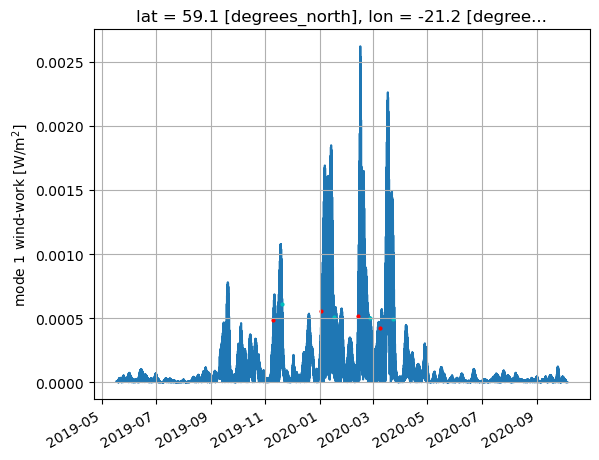

In [10]:
fig,ax = plt.subplots()
np.abs(wind_work['NISKINE M1 mode1 wind-work']).plot(ax=ax,zorder=-1)
ax.grid();#ax.axhline(0.0005)
ax.scatter(ti,np.abs(wind_work['NISKINE M1 mode1 wind-work'].sel(time=ti)),s=4,c='r',zorder=1)
ax.scatter(tf,np.abs(wind_work['NISKINE M1 mode1 wind-work'].sel(time=tf)),s=4,c='c',zorder=1)

In [11]:
#MLD loading
mld_da = xr.DataArray(data=mld_all.mld_da_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='da')
mld_dt = xr.DataArray(data=mld_all.mld_dt_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='dt')


In [13]:
#Local MLD
mld = mld_da.sel(lon=lon,lat=lat,method='nearest')

In [15]:
def plot_event2D(ds,v,ti,tf,months,**kwargs):
    fig,axs = plt.subplots(1,len(ti),figsize=(5*len(ti),6))
    for i in range(len(ti)):
        ds_filt.sel(time=slice(ti[i],tf[i]))[v].plot(ax=axs[i],y='z',yincrease=False,**kwargs)
        axs[i].axhline(mld.sel(month=months[i]),c='c',lw=2)
        axs[i].set_title('Month %s'%months[i])
    return fig,ax

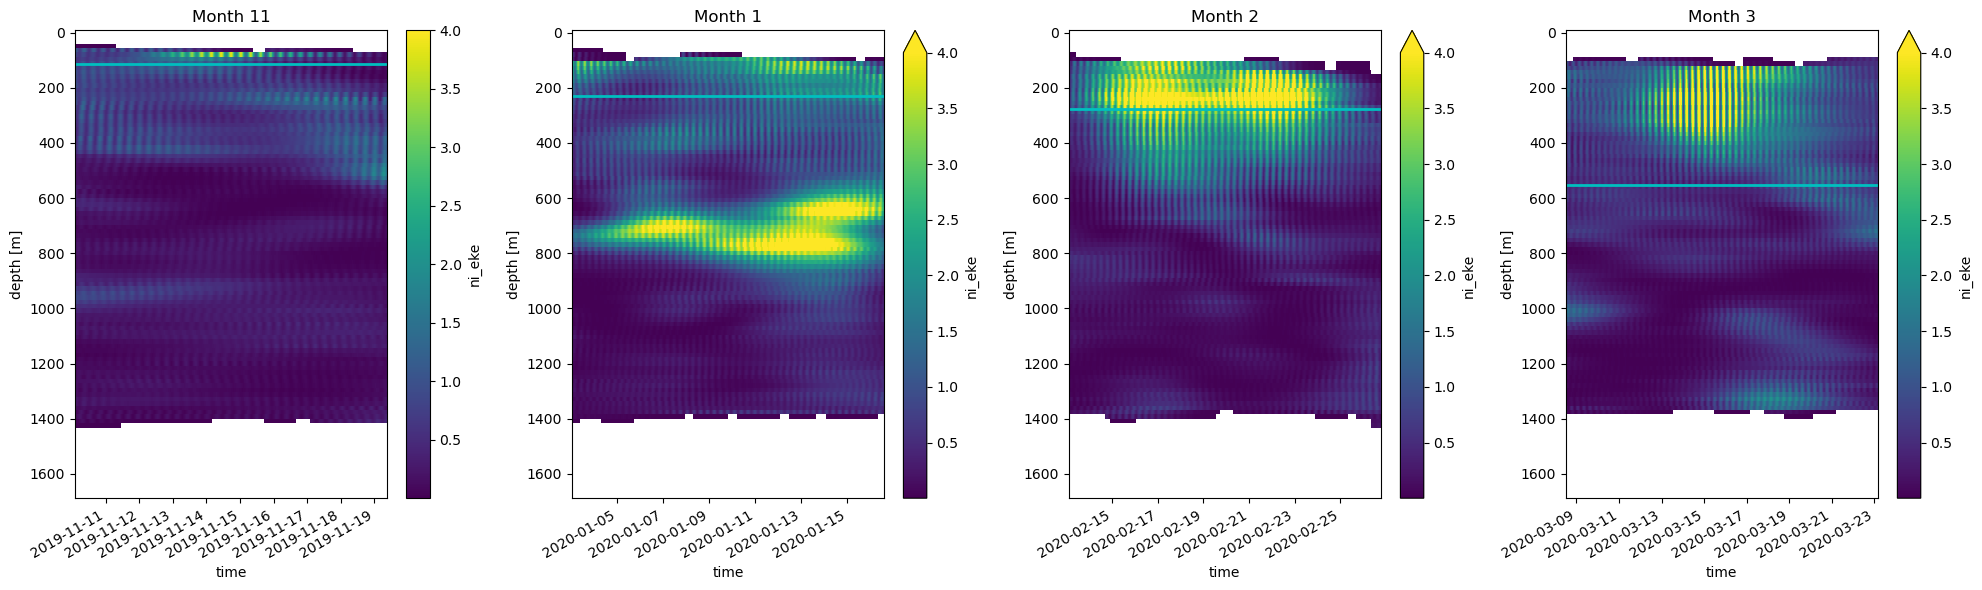

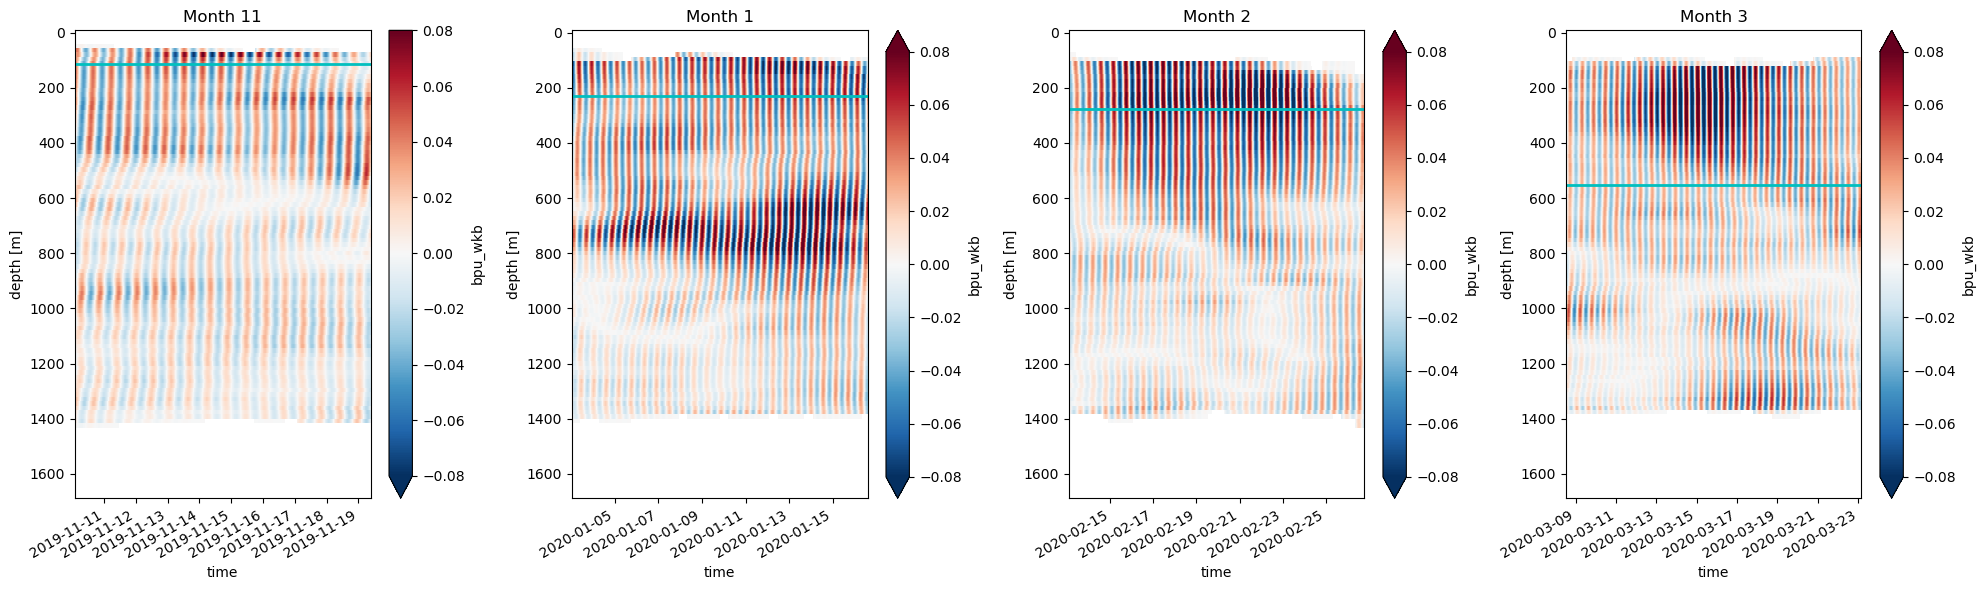

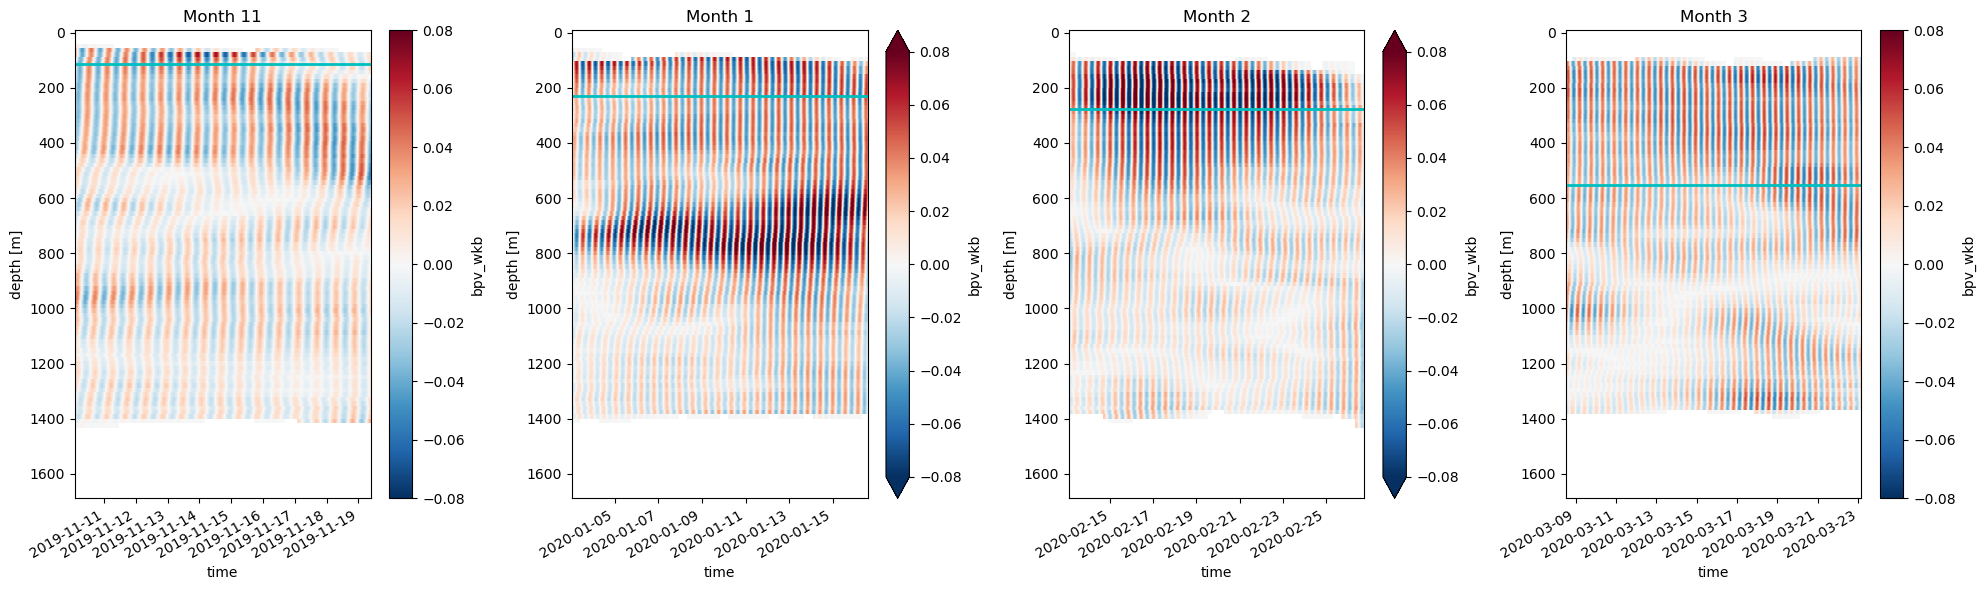

In [16]:
#NI EKE
fig,ax = plot_event2D(ds_filt,'ni_eke',ti,tf,months,**{'vmax':4})
fig.tight_layout()
#NI u
fig,ax = plot_event2D(ds_filt,'bpu_wkb',ti,tf,months,**{'vmax':0.08})
fig.tight_layout()
#NI v
fig,ax = plot_event2D(ds_filt,'bpv_wkb',ti,tf,months,**{'vmax':0.08})
fig.tight_layout()

In [35]:
import matplotlib.pylab as plb
n = len(ti)
colors = plb.cm.Blues_r(np.linspace(0,0.7,n))

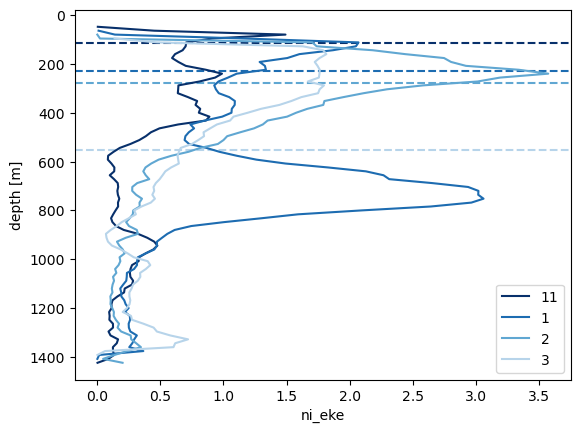

In [36]:
fig,ax = plt.subplots()
for i in range(len(ti)):
    ds_filt.sel(time=slice(ti[i],tf[i])).ni_eke.mean('time').plot(ax=ax,y='z',yincrease=False,label=str(months[i]),
                                                                  c=colors[i],zorder=1)
    ax.axhline(mld.sel(month=months[i]),c=colors[i],zorder=-1,ls='--')
ax.legend();#ax.grid();

In [20]:
import seaborn as sns

In [31]:
wind_bin = [wind_work['NISKINE M1 mode1 wind-work'].sel(time=slice(ti[i],tf[i])).mean() for i in range(len(ti))]
mld_bin = [mld.sel(month=months[i]) for i in range(len(ti))]
eke_bin = [ds_filt['ni_eke'].sel(time=slice(ti[i],tf[i])).mean()*100 for i in range(len(ti))]

Text(0.5, 0, 'MLD')

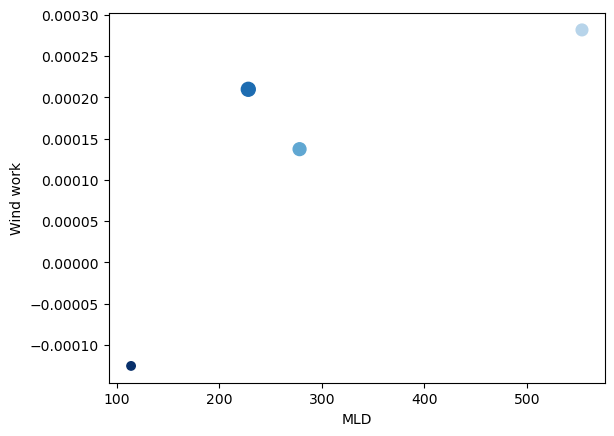

In [37]:
plt.scatter(x=mld_bin,y=wind_bin,s=eke_bin,c=colors)
plt.ylabel('Wind work');plt.xlabel('MLD')

### Comment Sam Kelly:
A detailed figure showing some near-inertial velocities and mixed layer depth after a wind wind event would be useful for visualizing the scale of the response and vertical propagation.  Maybe one wind event with a medium (but still observable) mixed layer and one with a super deep mixed layer?